<img src='logo.png'><br>
* ref : <a href='https://www.kaggle.com/mlg-ulb/creditcardfraud'>https://www.kaggle.com/mlg-ulb/creditcardfraud</a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, f1_score, precision_score , recall_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score
from sklearn.preprocessing import Binarizer

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler 
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.linear_model import LogisticRegression
sns.set()

In [2]:
def my_eval(y_val, pred, proba, th):  #avg='binary'
        accuracy = accuracy_score(y_val, pred)
        precision = precision_score(y_val, pred)
        recall = recall_score(y_val, pred)
        f1 = f1_score(y_val, pred)
        matrix = confusion_matrix(y_val, pred)
        print(f'정확도{accuracy:.4f} 정밀도:{precision:.4f} 재현률:{recall:.4f} f1:{f1:.4f}')
        print("오차행렬\n", matrix)
        # cls_report = classification_report(y_val, pred)

        # --------------- 양성 평가를 위한 차트 : precision_recall_curv() -------------------    
        # plot_precision_recall_curve(model, 문제지2, 정답지2)
        precisions, recalls, ths = precision_recall_curve(y_val, proba[:, 1])
        plt.title("precision recall curv %0.2f %0.4f"%(th,f1))
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("threadhold")
        plt.ylabel("value")
        plt.plot(ths, precisions[:ths.shape[0]], "b", label="precision")
        plt.plot(ths, recalls[:ths.shape[0]], "r", linestyle='--', label="recall")
        plt.grid()
        plt.legend()
        plt.show()
        
        
        # --------------- 양성 평가를 위한 차트 : roc_auc_score(), roc_curve() -------------------
        auc_score = roc_auc_score(y_val, proba[:, 1])

        fprs, tprs, ths = roc_curve(y_val, proba[:, 1])
        plt.title("roc curv %0.4f" % auc_score)
        # plt.title(f"precision recall curv %0.4f" % f1)
        plt.xlabel("FPR(1-specificity)")
        plt.ylabel("TPR")
        plt.grid()
        plt.plot(fprs, tprs, "b")
        plt.plot([0, 1], [0, 1], '--', color='black')
        plt.show()


def split_fit_score(X, y, model=None, test_size=0.2, th_list=None):

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size,random_state=1414
                                                            ,stratify=y) #shuffle=False, 

        model.fit(X_train, y_train)
        pred = model.predict(X_test)                                        #[0  1]              th:0.5
        proba = model.predict_proba(X_test)                                 #[[.7 >.3] [.4  <.6]]  --> [0  1]
        
        # ------------------ proba : 양성 점수 측정을 위한 예측 확률값 ---------------
        # proba 리턴값 : ndarray of shape (n_samples, n_classes)  150*3
        # [
        #     [0.4 0.6]  --> 1
        #     [0.7 0.3]  --> 0
        #     [0.42 0.58] -> 1
        # ]
        
        if th_list == None:
            #------------------방법1 ) 임계치 0.5(기본값)으로 점수 출력 ---------------
            my_eval(y_test, pred, proba, 0.5)                        # 점수def호출
 
        else:
            # ----------------방법2) 임계치 조정해가면서 최적의 점수 찾기---------------
            # (24 양성인데 틀리게예측) --> 임계치 낮춘다 == 양성학습데이터늘린다  == 양성점수를 올린다 
            th_list = [0, 0.35 , 0.38, 0.42, 0.45, 0.5, 1]
            for th in th_list:
                    binz = Binarizer(threshold=th)                              # [[.7 .3] [.4  .6]]   th:0.2
                    pred_binz = binz.fit_transform(proba[:, 1].reshape(-1,1))   # [  th<.3] [  th<.6]]  --> [1 1]
                    print(th)
                    my_eval(y_test, pred_binz, proba, th)                       #점수def호출

## 데이터 로드 

In [3]:
df = pd.read_csv("creditcard.csv")
df.drop(['Time'], axis=1,  inplace=True)
y = df['Class']
X = df.drop(['Class'], axis=1)
y.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## EDA

In [4]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


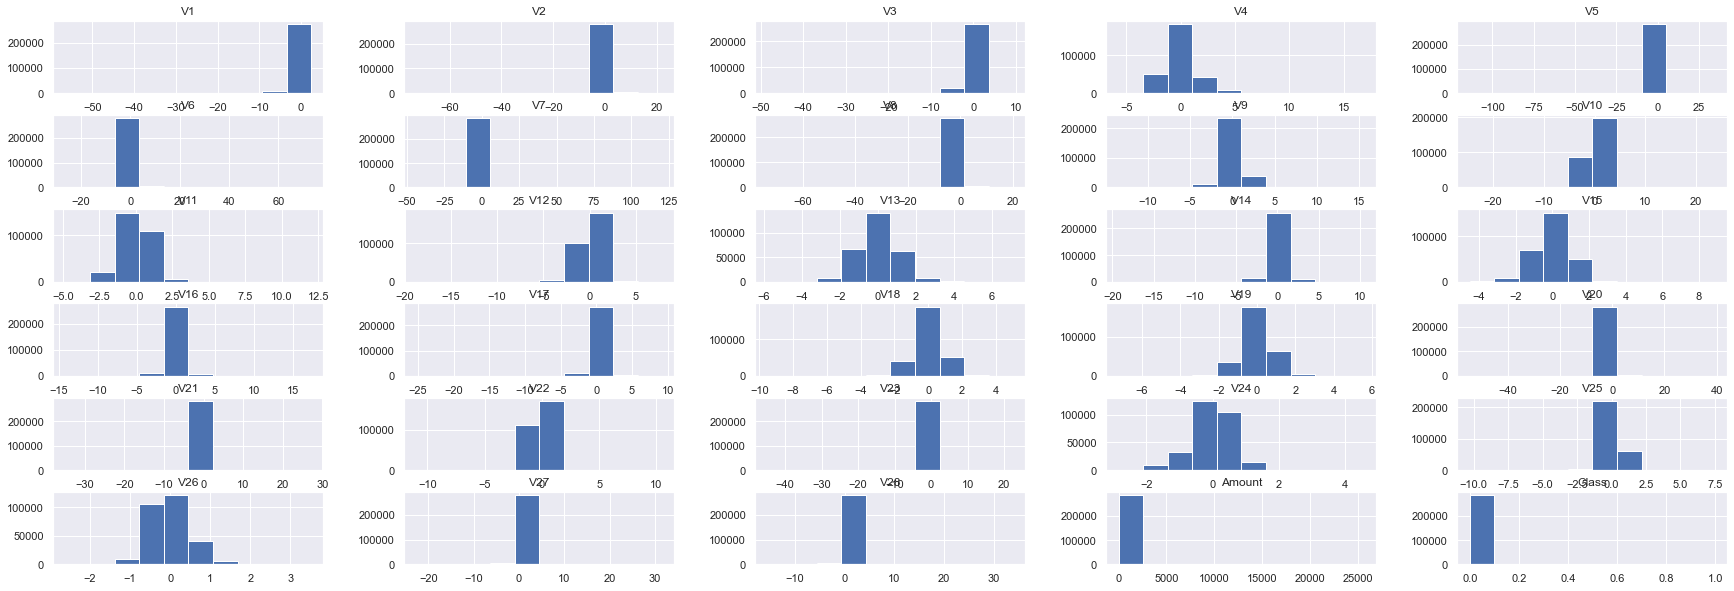

In [5]:
df.hist(figsize=(30,10))
plt.show()

Class 피쳐와 (+) 상관관계 TOP-n Index(['Class', 'V11', 'V4', 'V2', 'V21'], dtype='object')
Class 피쳐와 (-) 상관관계 TOP-n Index(['V17', 'V14', 'V12', 'V10', 'V16'], dtype='object')


<AxesSubplot:>

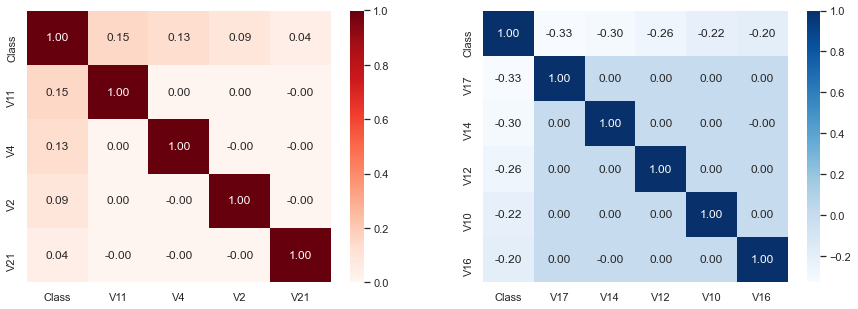

In [6]:
#### Class에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

top_corr_large  = df.corr().nlargest(5, 'Class').index
print("Class 피쳐와 (+) 상관관계 TOP-n", top_corr_large)
sns.heatmap(df[top_corr_large].corr(), annot=True, cmap='Reds', fmt='0.2f' , ax=ax1)

top_corr_small = df.corr().nsmallest(5, 'Class').index
print("Class 피쳐와 (-) 상관관계 TOP-n", top_corr_small)
sns.heatmap(df[['Class','V17', 'V14', 'V12', 'V10', 'V16']].corr(), annot=True, cmap='Blues', fmt='0.2f' , ax=ax2)
# plt.show()

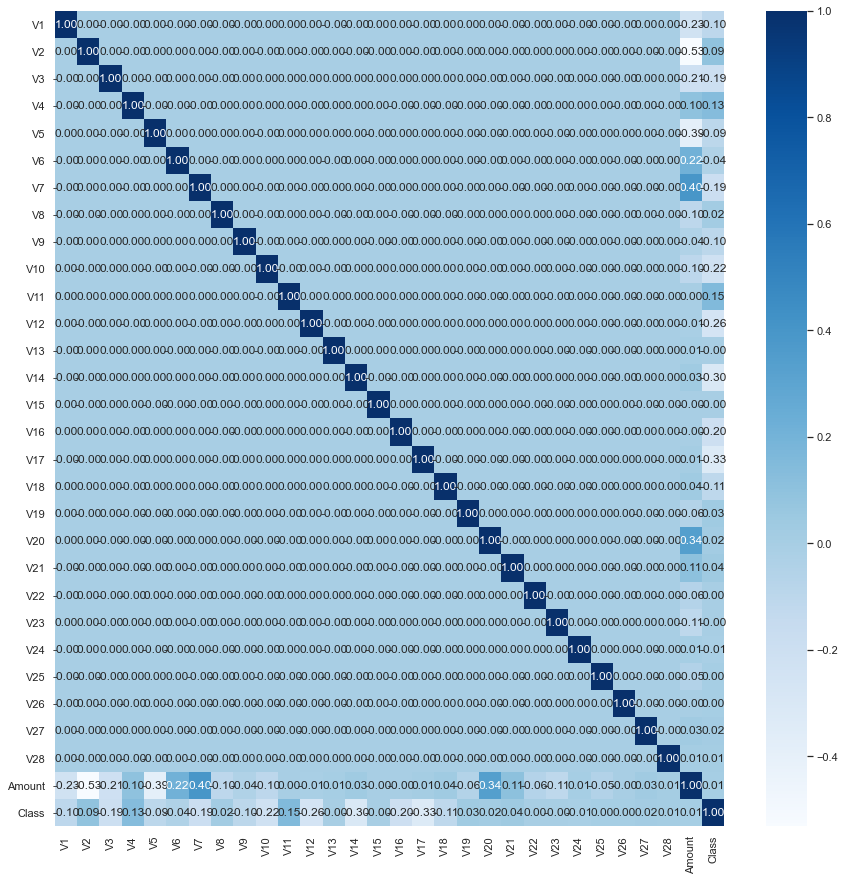

In [7]:
fig, ax = plt.subplots(figsize=(15,15))     
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="Blues")
plt.show()

In [8]:
# print(df['V17'].describe())
# sns.boxplot(x=df['V17'].value_counts())
# sns.swarmplot(x=df['V17'].value_counts())

In [9]:
# print(df['V14'].describe())
# sns.boxplot(x=df['V14'].value_counts())
# sns.swarmplot(x=df['V14'].value_counts())

In [10]:
# sns.boxplot(x="Class", y="V14", data=df)
# plt.show()

## 스케일링

In [11]:
# X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
for sc in scalers:
    sc.fit(X_train['Amount'].values.reshape(-1,1))
    train_sc_arr = sc.transform(X_train['Amount'].values.reshape(-1,1))   #[2 2 2 2 2 2 2 2 2 2 2...]
    test_sc_arr = sc.transform(X_test['Amount'].values.reshape(-1,1))
    X_train['Amount_'+ sc.__class__.__name__[:3]] = train_sc_arr #.reshape(-1,1)
    X_test ['Amount_'+ sc.__class__.__name__[:3]] = test_sc_arr #.reshape(-1,1)    

In [12]:
XX = X_train.append(X_test)
yy = y_train.append(y_test)
print(X_train.shape, X_test.shape, XX.shape)
print(y_train.shape, y_test.shape, yy.shape)

XX_std = XX.drop(['Amount','Amount_Min','Amount_Rob'], axis=1)

(227845, 32) (56962, 32) (284807, 32)
(227845,) (56962,) (284807,)


정확도0.9993 정밀도:0.8889 재현률:0.6809 f1:0.7711
오차행렬
 [[56860     8]
 [   30    64]]


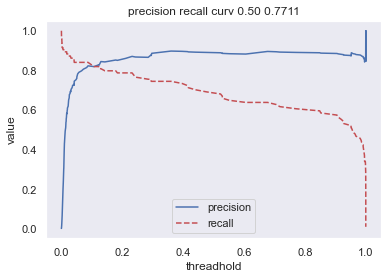

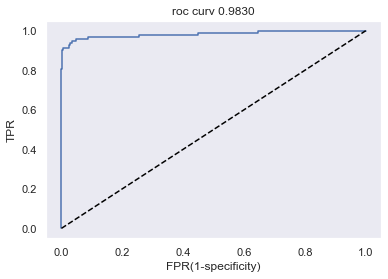

In [13]:

X_train, X_test, y_train, y_test = train_test_split(XX_std, yy, test_size=0.2, shuffle=True)


model = LogisticRegression(penalty='l2', dual=False,C=1.0,random_state=1414,
                           max_iter=100, multi_class='auto')

model.fit(X_train, y_train)
pred = model.predict(X_test)                                        #[0  1]              th:0.5
proba = model.predict_proba(X_test)        
my_eval(y_test, pred, proba, 0.5)   #-------------------------------

#정확도0.9995 정밀도:0.9250 재현률:0.7629 f1:0.8362